## Set working directory and output directory

In [1]:
import os
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\mushrooms\Mushroom_edible_gallery\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [2]:
os.chdir(os.path.dirname(working_dir))

In [3]:
working_dir = os.getcwd()
print(f"You have now changed your working directory to {working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\mushrooms\Mushroom_edible_gallery


In [4]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


<hr>

# Data distribution visualisation

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def images_percentage_distribution(image_dirs, save_path=None):

    # Creates a list that collects images per specie
    images_per_specie = {}
    for species in os.listdir(image_dirs):
        species_path = os.path.join(image_dirs, species)
        if os.path.isdir(species_path):
            images_per_specie[species] = len([img for img in os.listdir(species_path) if img.endswith(('.png', 'jpg', 'jpeg'))])
            

    # Convert this list to a dataframe
    df = pd.DataFrame(list(images_per_specie.items()), columns=['Species', 'Count'])

    # Calculate the percentage of images per specie
    df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

    # Calculate the highest, the lowest and mean value of the distribution
    highest = df.loc[df['Percentage'].idxmax()]
    lowest = df.loc[df['Percentage'].idxmin()]
    mean_percentage = df['Percentage'].mean()
    mean_count = df['Count'].mean()


    # Create a barplot to visualize this distibution of images per specie
    plt.figure(figsize=(15, 8))
    plt.bar(df['Species'], df['Percentage'], color='skyblue')
    plt.axhline(y=mean_percentage, color='r', linestyle='--')
    plt.xlabel('Species')
    plt.ylabel('Percentage (%)')
    plt.title('Percentage distribution of images per specie')
    plt.xticks(rotation=90)

    # Adds extra text to the top of the barplot
    plt.gcf().text(0.40, 0.85, f"Mean percentage: {mean_percentage:.2f}% ({mean_count:.0f} images)", fontsize=10)
    plt.gcf().text(0.40, 0.82, f"Highest percentage: {highest['Species']} - {highest['Percentage']:.2f}% ({highest['Count']} images)", fontsize=10)
    plt.gcf().text(0.40, 0.79, f"Lowest percentage: {lowest['Species']} - {lowest['Percentage']:.2f}% ({lowest['Count']} images)", fontsize=10)

    # If save_path is given it will save an image of the barplot at the given path
    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
    
    # Shows the barplot
    plt.tight_layout()
    plt.show()
    
    return df
    

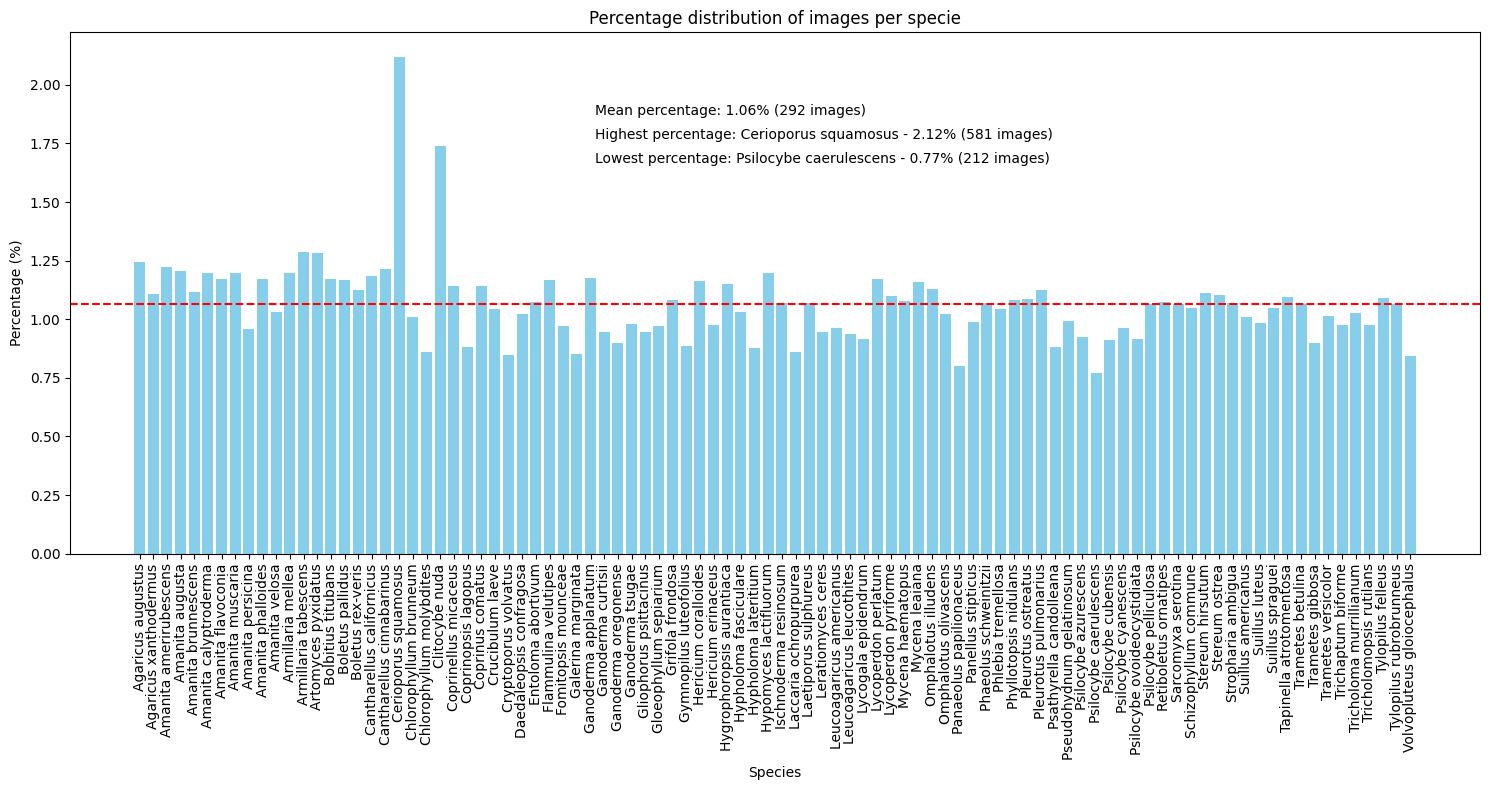

In [18]:
df_all_species = images_percentage_distribution(image_dirs = 'input/dataset/raw/MO_94', save_path='outputs/v1/raw_percentage_distribution.png')

## Balancing the images before splitting into train/validation/test sets

Since there are 2 species that has more images than the others, undersampling those before splitting to the train/validation/train sets maybe will help the modeltraining.

In [26]:
top5_counts = df_all_species.sort_values(by='Count', ascending=False).head(5)
bottom5_counts = df_all_species.sort_values(by='Count',ascending=True).head(5)
print("The 5 species with the most amount of images:")
print(top5_counts)


print("\nThe 5 species with the least amount of images:")
print(bottom5_counts)

The 5 species with the most amount of images:
                 Species  Count  Percentage
19  Cerioporus squamosus    581    2.117733
22        Clitocybe nuda    477    1.738655
12  Armillaria tabescens    353    1.286678
13   Artomyces pyxidatus    352    1.283033
0      Agaricus augustus    341    1.242938

The 5 species with the least amount of images:
                       Species  Count  Percentage
70      Psilocybe caerulescens    212    0.772736
60     Panaeolus papilionaceus    220    0.801895
93  Volvopluteus gloiocephalus    231    0.841990
27        Cryptoporus volvatus    233    0.849280
32          Galerina marginata    234    0.852925


Lets create a function that will balance the target species to the mean value of 'Count' that we saw in the previous barplot.

In [28]:
import os
import shutil
import random
"""
This is a function that will balance images in specific
directories so that the species images are more balanced
before splitting into train/validation/test sets.
"""
def balance_species_images(image_dirs, target_dir, species_to_balance, target_count):
    
    # If the target_dir diesn´t exists, it will be created.
    os.makedirs(target_dir, exist_ok=True)
    
    for species in species_to_balance:
        species_path = os.path.join(image_dirs, species)
        unused_images_dir = os.path.join(target_dir, species)
        os.makedirs(unused_images_dir, exist_ok=True)
        
        # List for all species images
        images = [img for img in os.listdir(species_path) if img.endswith(('.png', 'jpg', 'jpeg'))]
        
        # Counts how many images that shall be transferred
        num_images_to_move = len(images) - target_count
        if num_images_to_move > 0:
            # Randomly choose images to transfer
            images_to_move = random.sample(images, num_images_to_move)
            
            for img in images_to_move:
                src = os.path.join(species_path, img)
                dest = os.path.join(unused_images_dir, img)
                shutil.move(src, dest)
                
            print(f"{num_images_to_move} images move for species '{species} to {unused_images_dir}")
        else:
            print(f"Species '{species}' has less or equal to target count of images. No images was moved")
            

Since we got the mean value before of the raw distribution and the names of the two species that had the most. <br>
We can call the function with that information:

In [30]:
species_to_balance=['Cerioporus squamosus', 'Clitocybe nuda']
target_count=292
balance_species_images('input/dataset/raw/MO_94', 'input/dataset/unused_images', species_to_balance, target_count)

289 images move for species 'Cerioporus squamosus to input/dataset/unused_images\Cerioporus squamosus
185 images move for species 'Clitocybe nuda to input/dataset/unused_images\Clitocybe nuda


Now lets see the image distribution after we balanced the species:

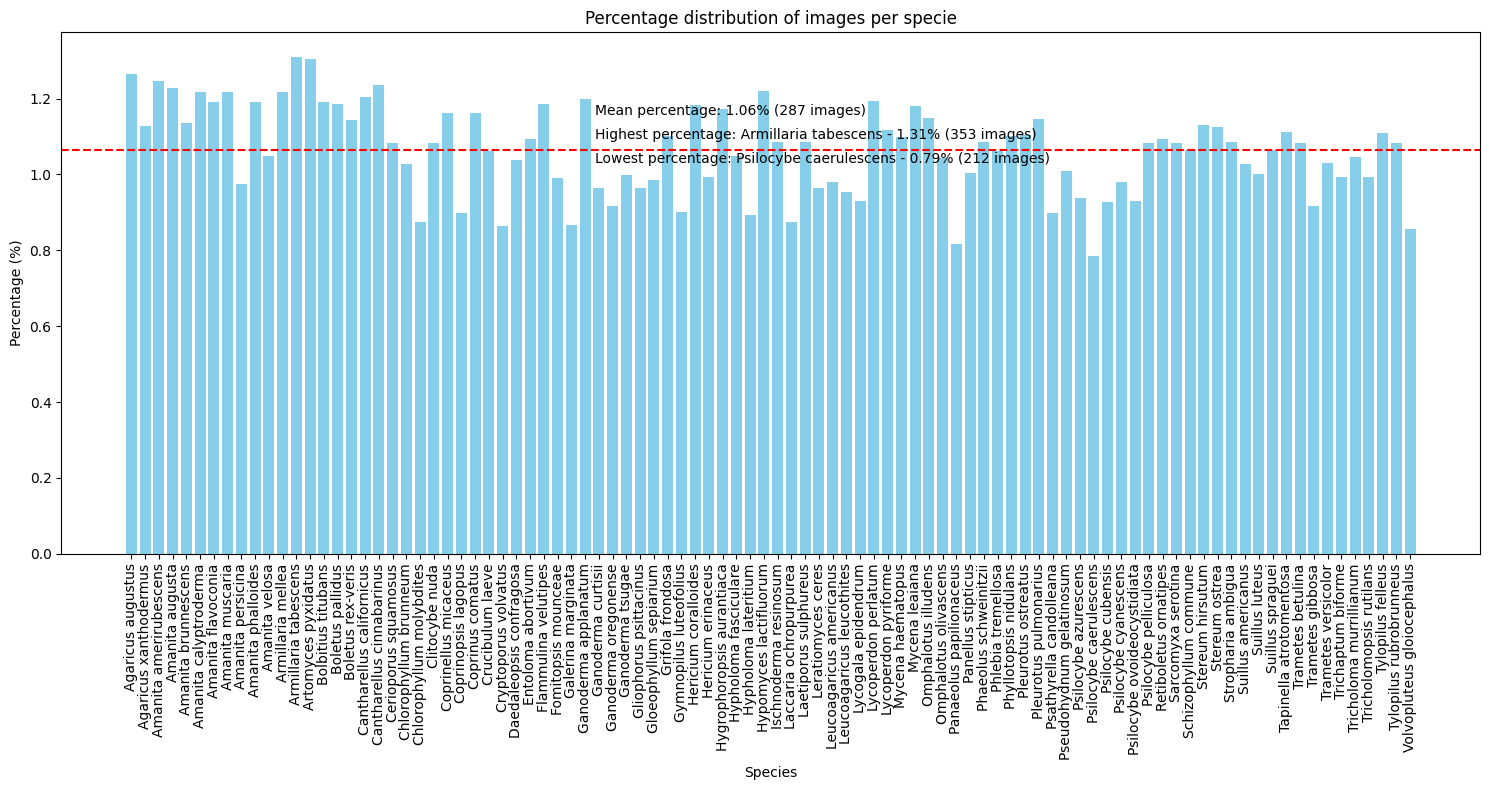

In [31]:
df_all_species = images_percentage_distribution(image_dirs = 'input/dataset/raw/MO_94', save_path='outputs/v1/balanced_percentage_distribution.png')